In [65]:
from src import PINN 
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)



In [66]:
import os

# os.environ['TF_XLA_FLAGS'] = '—tf_xla_enable_xla_devices'
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,4'
tf.debugging.set_log_device_placement(False)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  3


In [67]:
class Heatsolver(PINN.PINNSolver):
    def fun_r(self, t, x, u, u_t, u_x, u_xx,epsilon=.02):
        """Residual of the PDE"""
        return u_t -1 * u_xx


In [68]:
# Define initial condition
def fun_u_0(x):
    return tf.cos(pi * x/2)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)


# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 2.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

In [69]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
def heat_model(num_neurons_per_layer=40,activation='tanh'):
    # define the layers
    x_in = Input(shape=(2,))
    x1=Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get(activation),
                                         kernel_initializer='glorot_normal')(x_in)
    x1_=Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get(activation),
                                         kernel_initializer='glorot_normal')(x1)
    x2=Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get(activation),
                                         kernel_initializer='glorot_normal')(x1_)
    x2_=Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get(activation),
                                         kernel_initializer='glorot_normal')(x2)

    x3_=Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get(activation),
                                         kernel_initializer='glorot_normal')(x2_)
     
    x3=Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get(activation),
                kernel_initializer='glorot_normal')(x3_)
    
    
    x_out_=Dense(1)(x3)

    model=Model(inputs=x_in, outputs=x_out_)
    return model

In [70]:
from time import time


# Initialize model
model = PINN.PINN_NeuralNet(lb, ub)
model.build(input_shape=(None,2))


# model=heat_model()
# Initilize PINN solver
solver = Heatsolver(model, X_r)

# Decide which optimizer should be used
mode = 'TFoptimizer'
# mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_data, u_data, N=20001)
    
elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 4.97545213e-01
It 00050: loss = 3.83504368e-02
It 00100: loss = 3.39977257e-03
It 00150: loss = 1.13486522e-03
It 00200: loss = 1.66751258e-03
It 00250: loss = 7.49266357e-04
It 00300: loss = 4.82294126e-04
It 00350: loss = 9.93683236e-04
It 00400: loss = 4.72162938e-04
It 00450: loss = 9.95559152e-04
It 00500: loss = 2.38832342e-03
It 00550: loss = 3.01054068e-04
It 00600: loss = 1.62534459e-04
It 00650: loss = 8.54975544e-04
It 00700: loss = 3.90387519e-04
It 00750: loss = 1.15332528e-04
It 00800: loss = 2.03042058e-03
It 00850: loss = 2.10872808e-04
It 00900: loss = 3.37680453e-04
It 00950: loss = 3.22791864e-04
It 01000: loss = 8.16025492e-03
It 01050: loss = 3.23030021e-04
It 01100: loss = 2.33558851e-04
It 01150: loss = 1.88037680e-04
It 01200: loss = 1.58209979e-04
It 01250: loss = 1.38338786e-04
It 01300: loss = 1.22709229e-04
It 01350: loss = 1.11072921e-04
It 01400: loss = 1.02094833e-04
It 01450: loss = 9.41691324e-05
It 01500: loss = 8.79926956e-05
It 01550

In [71]:
mode = 'ScipyOptimizer'

# Start timer
t0 = time()

if mode == 'TFoptimizer':
    # Choose optimizer
    lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])
    optim = tf.keras.optimizers.Adam(learning_rate=lr)
    solver.solve_with_TFoptimizer(optim, X_data, u_data, N=20001)
    
elif mode == 'ScipyOptimizer':
    solver.solve_with_ScipyOptimizer(X_data, u_data,
                            method='L-BFGS-B',
                            options={'maxiter': 50000,
                                     'maxfun': 50000,
                                     'maxcor': 50,
                                     'maxls': 50,
                                     'ftol': 1.0*np.finfo(float).eps})

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))


Computation time: 1.3345146179199219 seconds


In [52]:
def plot_solution( **kwargs):
    N = 600
    tspace = np.linspace(lb[0], ub[0], N+1)
    xspace = np.linspace(lb[1], ub[1], N+1)
    T, X = np.meshgrid(tspace, xspace)
    Xgrid = np.vstack([T.flatten(),X.flatten()]).T
    upred = model(tf.cast(Xgrid,DTYPE))
    U = upred.numpy().reshape(N+1,N+1)
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_zlabel('$u_\\theta(t,x)$')
    ax.view_init(35,35)
    return tspace,xspace,U,ax

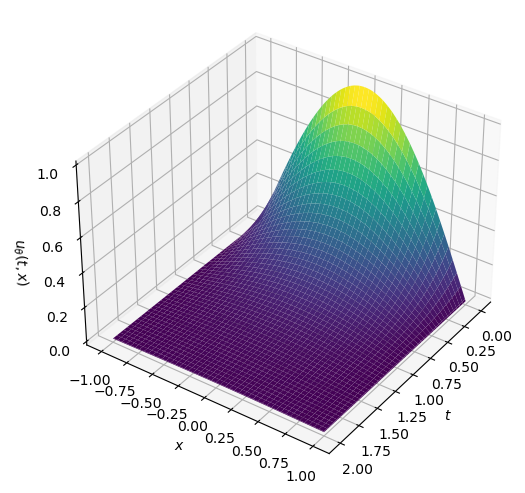

In [53]:
t,x,U,ax=plot_solution()

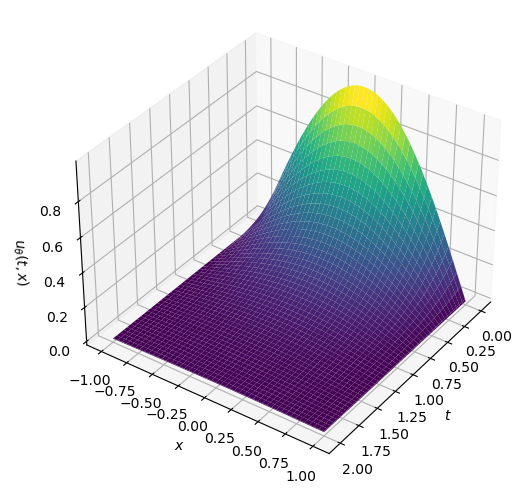

In [72]:
t,x,U,ax=solver.plot_solution()

In [73]:
def analytic_sol(t,x):
    return np.exp(-np.pi**2*t/4)*np.cos(np.pi*x/2)

In [74]:
dt=0.001

Text(0.5, 1.0, 'Diffusion analytical solution, t=2.0')

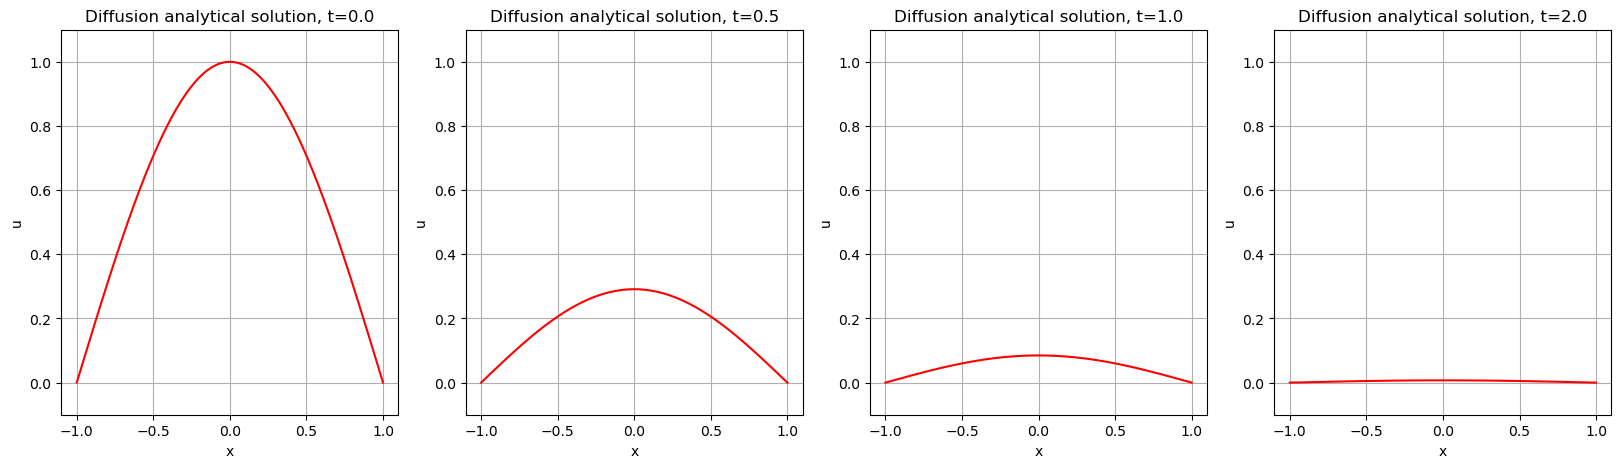

In [75]:
plt.figure(figsize=[20,5])
plt.subplot(141)

plt.plot(x,analytic_sol(0*dt,x),'r')  
plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=0.0')

plt.subplot(142)
plt.plot(x,analytic_sol(500*dt,x),'r')  
plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=0.5')

plt.subplot(143)

plt.plot(x,analytic_sol(1000*dt,x),'r')  
plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=1.0')

plt.subplot(144)

plt.plot(x,analytic_sol(2000*dt,x),'r') 
plt.ylim([-0.1,1.1]) 
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=2.0')

# plt.savefig('Diffusion_1d_sol_analytical.eps')


Text(0.5, 1.0, 'Diffusion analytical solution, t=2.0')

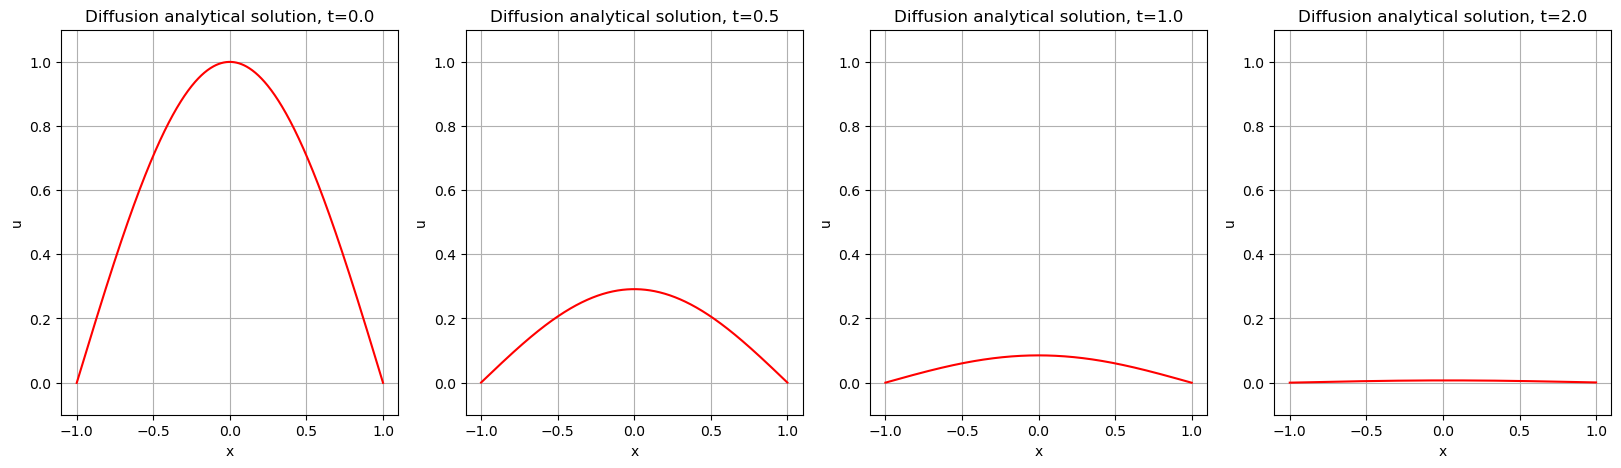

In [76]:
plt.figure(figsize=[20,5])
plt.subplot(141)

plt.plot(x,U[:,0],'r') 
plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=0.0')

plt.subplot(142)
plt.plot(x,U[:,150],'r') 
plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=0.5')

plt.subplot(143)

plt.plot(x,U[:,300],'r')
plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=1.0')

plt.subplot(144)
plt.plot(x,U[:,600],'r') 
plt.ylim([-0.1,1.1]) 
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Diffusion analytical solution, t=2.0')

# plt.savefig('Diffusion_1d_sol_analytical.eps')


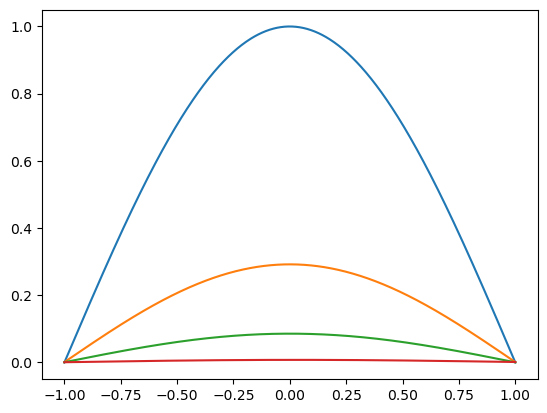

In [77]:
plt.plot(x,U[:,0])
plt.plot(x,U[:,150])
plt.plot(x,U[:,300])
plt.plot(x,U[:,600])


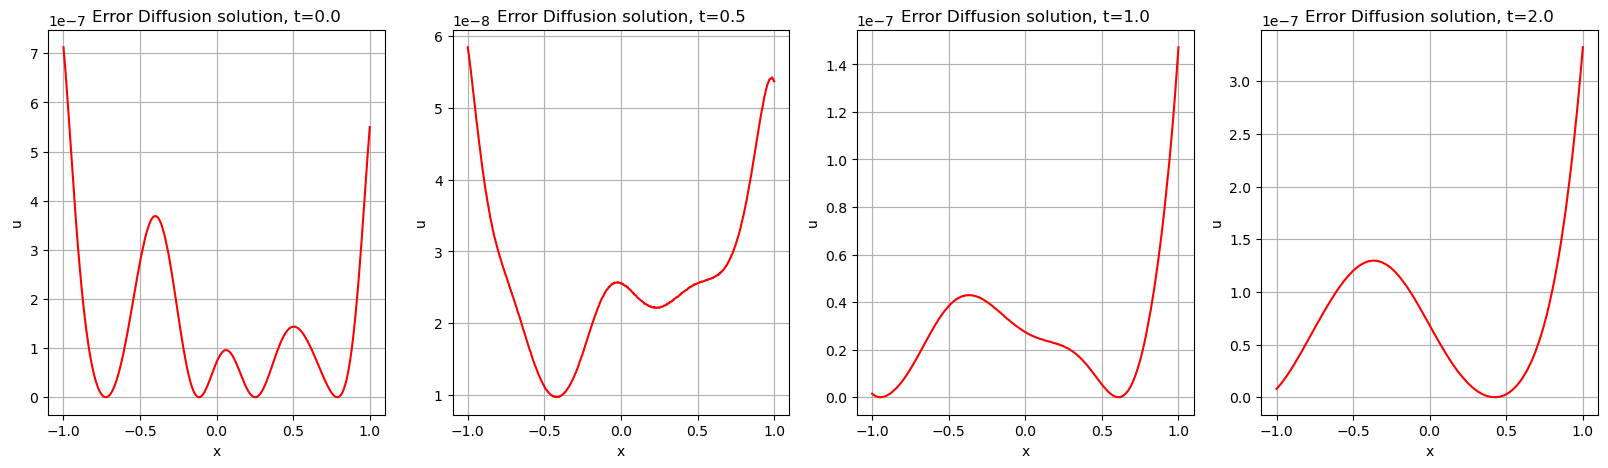

In [81]:
plt.figure(figsize=[20,5])
plt.subplot(141)

plt.plot(x,np.abs(analytic_sol(0*dt,x)-U[:,0])**2,'r')  
# plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Error Diffusion solution, t=0.0')

plt.subplot(142)
plt.plot(x,np.abs(analytic_sol(500*dt,x)-U[:,150])**2,'r')  
# plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Error Diffusion solution, t=0.5')

plt.subplot(143)
plt.plot(x,np.abs(analytic_sol(1000*dt,x)-U[:,300])**2 ,'r')
# plt.ylim([-0.1,1.1])
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Error Diffusion solution, t=1.0')

plt.subplot(144)

plt.plot(x,np.abs(analytic_sol(2000*dt,x)-U[:,600])**2,'r')
# plt.ylim([-0.1,1.1]) 
plt.xlabel('x')
plt.ylabel('u')
plt.grid(True)
plt.title('Error Diffusion solution, t=2.0')

plt.savefig('Diffusion_1d_sol_PINN.eps')


<AxesSubplot:xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

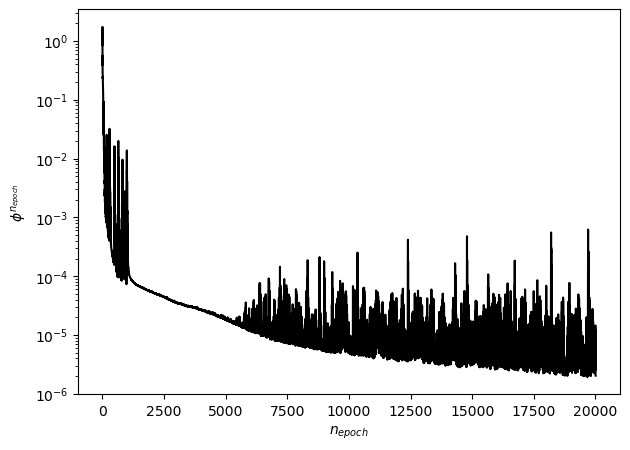

In [14]:
solver.plot_loss_history()
